# 音樂曲風分類 with CNN

## 載入套件

In [1]:
import torch
from torch import nn
import torchaudio
import torchaudio.transforms as T
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import IPython
from IPython.display import Audio
import matplotlib.pyplot as plt
import os
import math
import audio_util
import numpy as np

## 設定參數

In [2]:
PATH_DATASETS = "./audio" # 預設路徑
BATCH_SIZE = 10  # 批量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

## 步驟1：下載 GTZAN資料集，並建立 Dataset

In [3]:
dataset_GTZAN = torchaudio.datasets.GTZAN(PATH_DATASETS, download=True)

In [4]:
dataset_GTZAN[0]

(tensor([[ 0.0073,  0.0166,  0.0076,  ..., -0.0556, -0.0611, -0.0642]]),
 22050,
 'blues')

In [5]:
dataset_GTZAN[0][0].shape

torch.Size([1, 661794])

In [6]:
dataset_GTZAN[1][0].shape

torch.Size([1, 661794])

In [7]:
f'{661794 / 22050} 秒'

'30.013333333333332 秒'

In [8]:
# 切成 5 段
waveform , sample_rate, label = dataset_GTZAN[0]
segment_length = int(waveform.shape[1] / 5)
for i in range(5):
    audio_util.play_audio(waveform[:, i*segment_length:(i+1)*segment_length], sample_rate)
    print(waveform[:, i*segment_length:(i+1)*segment_length].shape[1])

132358


132358


132358


132358


132358


In [9]:
audio_util.play_audio(waveform, sample_rate)

## 步驟2：資料清理，此步驟無需進行

## 步驟3：特徵工程

In [10]:
# label類別
gtzan_genres = [
    "blues",
    "classical",
    "country",
    "disco",
    "hiphop",
    "jazz",
    "metal",
    "pop",
    "reggae",
    "rock",
]

In [11]:
slice_count = 5
n_mfcc = 40

class GTZAN_DS(Dataset):
    def __init__(self, dataset1):
        self.dataset1 = dataset_GTZAN
        
    def __len__(self):
          return len(self.dataset1)  

    def __getitem__(self, n):
        waveform , sample_rate, label = self.dataset1[n]
            
        mfcc_transform = T.MFCC(
            sample_rate=sample_rate,
            n_mfcc=n_mfcc,   # MFCC 個數
        )
        
        mfcc_list=[]
        segment_length = int(waveform.shape[1] / slice_count)
        for i in range(5):
            mfcc = mfcc_transform(waveform[:, i*segment_length:(i+1)*segment_length])
            # print(mfcc.shape)
            mfcc_list.append(mfcc[:, :, :660])
            
        # 5段合成
        mfcc_tensor = torch.cat(mfcc_list, dim=0)
        return mfcc_tensor, gtzan_genres.index(label)
    
dataset = GTZAN_DS(dataset_GTZAN)

In [12]:
dataset[0][0].shape

C:\anaconda3\lib\site-packages\torchaudio\functional\functional.py:507: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


torch.Size([5, 40, 660])

In [13]:
dataset[0][0][4]

tensor([[ -78.0929, -113.1594, -110.7107,  ..., -118.7717,  -86.7612,
          -82.6054],
        [  58.5233,  103.5589,   99.4732,  ...,   64.5999,   74.4746,
           72.4951],
        [ -61.2960,  -87.2524,  -94.8755,  ...,  -96.3385,  -88.4778,
          -88.4652],
        ...,
        [ -14.3105,   -9.3861,  -11.8726,  ...,  -18.4032,  -14.1026,
           -8.7929],
        [ -30.3631,  -25.6588,  -17.3942,  ...,  -15.8074,  -10.2427,
          -22.1446],
        [ -20.2411,  -27.4453,  -18.6464,  ...,  -18.8495,  -12.5609,
          -17.3744]])

## 步驟4：資料分割

In [14]:
from torch.utils.data import random_split

test_size = int(len(dataset) * 0.2)
train_size = len(dataset) - test_size

train_ds, test_ds = random_split(dataset, [train_size, test_size])
len(train_ds), len(test_ds)

(800, 200)

In [15]:
test_ds[2][1]

3

## 建立 DataLoader

In [16]:
train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, BATCH_SIZE, shuffle=False)

## 步驟5：建立模型結構

In [17]:
# 建立模型
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            # Conv2d 參數： in-channel, out-channel, kernel size, Stride, Padding
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(52800, num_classes)
        # self.fc2 = nn.Linear(1280, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        #out = self.fc2(out)
        out = F.log_softmax(out, dim=1)
        return out

model = ConvNet().to(device)

## 步驟6：模型訓練

In [18]:
def score_model():
    model.eval()
    test_loss = 0
    correct = 0
    prediction_list = []
    target_list = []
    with torch.no_grad():
        for data, target in test_loader:
            # 重複 label，並重整 data，1筆變成5筆
            # if test_loss == 0: print(target, data.shape)
            target = target.repeat_interleave(slice_count)
            data = data.reshape(BATCH_SIZE * slice_count, 1, data.shape[2], data.shape[3])
            # if test_loss == 0: print(target, data.shape)
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target).item()

            # 預測
            output = model(data)

            # 計算正確數
            _, predicted = torch.max(output.data, dim=1)
            correct += (predicted == target).sum().item()
            prediction_list.extend(predicted.cpu().numpy())
            # print(predicted.cpu().numpy())
            target_list.extend(target.cpu().numpy())

    # 平均損失
    test_loss /= len(test_loader.dataset) 
    # 顯示測試結果
    batch = batch_idx * len(data)
    data_count = len(test_loader.dataset) * slice_count # 5倍筆數
    percentage = 100. * correct / data_count 
    print(f'平均損失: {test_loss:.4f}, 準確率: {correct}/{data_count}' + 
          f' ({percentage:.2f}%)\n')
    return prediction_list, target_list

In [20]:
epochs = 40
lr=0.01

# 設定優化器(optimizer)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_list = []    
for epoch in range(1, epochs + 1):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # if batch_idx == 0 and epoch == 1: print(target, data.shape)
        # 重複 label，並重整 data，1筆變成5筆
        target = target.repeat_interleave(slice_count)
        data = data.reshape(BATCH_SIZE * slice_count, 1, data.shape[2], data.shape[3])
        # if batch_idx == 0 and epoch == 1: print(target, data.shape)
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        # if batch_idx == 0 : print(output.shape, target.shape)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if (batch_idx+1) % 10 == 0:
            loss_list.append(loss.item())
            batch = (batch_idx+1) * len(data)
            data_count = len(train_loader.dataset) * slice_count # 5倍筆數
            percentage = (100. * (batch_idx+1) / len(train_loader))
            print(f'Epoch {epoch}: [{batch:5d} / {data_count}] ({percentage:.0f} %)' +
                  f'  Loss: {loss.item():.6f}')
    score_model()

平均損失: 0.1607, 準確率: 427/1000 (42.70%)

平均損失: 0.1460, 準確率: 510/1000 (51.00%)

平均損失: 0.1496, 準確率: 470/1000 (47.00%)

平均損失: 0.1585, 準確率: 462/1000 (46.20%)

平均損失: 0.1451, 準確率: 508/1000 (50.80%)

平均損失: 0.1692, 準確率: 485/1000 (48.50%)

平均損失: 0.1679, 準確率: 466/1000 (46.60%)

平均損失: 0.1851, 準確率: 472/1000 (47.20%)

平均損失: 0.2175, 準確率: 479/1000 (47.90%)

平均損失: 0.2030, 準確率: 465/1000 (46.50%)

平均損失: 0.2488, 準確率: 458/1000 (45.80%)

平均損失: 0.2600, 準確率: 515/1000 (51.50%)

平均損失: 0.2540, 準確率: 522/1000 (52.20%)

平均損失: 0.2648, 準確率: 493/1000 (49.30%)

平均損失: 0.2448, 準確率: 509/1000 (50.90%)

平均損失: 0.2729, 準確率: 521/1000 (52.10%)

平均損失: 0.2803, 準確率: 506/1000 (50.60%)

平均損失: 0.2960, 準確率: 481/1000 (48.10%)

平均損失: 0.2831, 準確率: 465/1000 (46.50%)

平均損失: 0.2697, 準確率: 518/1000 (51.80%)

平均損失: 0.2926, 準確率: 490/1000 (49.00%)

平均損失: 0.3290, 準確率: 482/1000 (48.20%)

平均損失: 0.3201, 準確率: 487/1000 (48.70%)

平均損失: 0.3126, 準確率: 510/1000 (51.00%)

平均損失: 0.3623, 準確率: 491/1000 (49.10%)

平均損失: 0.3758, 準確率: 488/1000 (48.80%)

平均損失: 0.3777

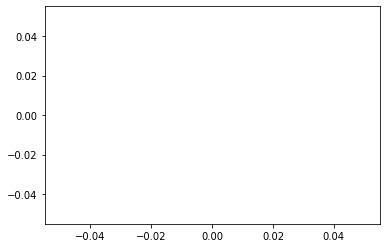

In [21]:
# 對訓練過程的損失繪圖
import matplotlib.pyplot as plt

plt.plot(loss_list, 'r')

## 步驟7：評分(Score Model)

In [22]:
prediction_list, target_list = score_model()

平均損失: 0.4199, 準確率: 514/1000 (51.40%)



In [23]:
' '.join([str(x) for x in prediction_list]), ' '.join([str(x) for x in target_list])

('5 8 2 8 9 5 0 2 2 2 9 3 9 8 3 8 4 8 1 1 7 3 7 3 4 2 9 0 6 0 1 1 1 1 1 2 9 2 0 2 4 2 8 0 8 3 4 3 5 3 3 7 7 7 7 9 0 0 0 8 1 1 1 1 1 1 1 1 1 1 2 0 0 2 2 2 4 8 8 9 3 6 9 2 9 9 2 2 2 2 6 6 6 6 6 4 9 0 9 5 1 1 5 1 1 8 5 2 5 8 2 5 5 5 5 4 4 0 4 4 7 1 9 7 5 8 2 8 7 3 0 8 0 8 4 0 7 2 1 3 5 5 5 0 0 2 2 1 1 1 4 8 8 8 8 3 4 8 8 8 8 0 0 8 3 4 4 8 6 6 3 3 4 3 9 7 9 7 2 9 9 8 2 8 5 6 6 6 6 6 9 9 3 9 9 5 2 7 1 2 2 8 2 8 0 8 3 3 4 7 6 6 6 6 6 9 0 5 5 5 9 9 3 3 3 3 9 2 2 9 7 7 7 7 7 1 1 1 1 1 9 9 0 9 9 1 1 1 1 1 3 0 4 5 8 1 1 1 1 1 7 7 8 7 7 9 4 2 3 3 6 6 6 9 8 6 6 6 0 6 5 5 5 5 5 2 2 9 2 2 9 3 9 9 3 5 5 5 5 9 5 2 7 7 5 1 1 1 1 1 3 3 9 3 3 2 2 3 9 9 8 4 8 8 8 9 2 9 7 2 9 5 8 8 9 8 3 8 8 4 0 8 4 4 4 8 4 4 4 4 0 0 1 0 0 1 1 1 9 2 7 7 7 5 7 7 7 7 7 7 1 2 2 8 8 1 5 1 1 1 3 5 3 9 2 1 1 1 1 1 9 9 7 5 7 0 9 2 0 4 5 2 5 0 0 3 3 0 9 8 0 0 9 9 9 2 2 0 9 2 4 3 4 4 7 1 1 1 1 1 0 9 4 0 4 6 6 6 6 6 2 4 8 8 9 6 6 6 6 6 4 4 6 4 4 9 3 9 3 3 1 1 1 1 1 3 0 7 7 7 9 9 2 2 2 9 9 9 9 8 9 7 7 3 7 1 1 1 1 1 4 7 3 3 9 4 8 6 6 

## 步驟8：評估

## 顯示混淆矩陣

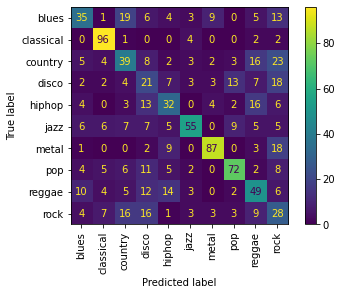

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(target_list, prediction_list)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gtzan_genres)
disp.plot()
plt.xticks(rotation=90);

In [25]:
# 實際預測 20 筆資料
predictions = []
target_list = []
with torch.no_grad():
    for i in range(20):
        data, target = test_ds[i]
        # 重複 label，並重整 data，1筆變成5筆
        #print(data.shape)
        data = data.reshape(slice_count, 1, data.shape[1], data.shape[2])
        data = data.to(device)
        output = torch.argmax(model(data), axis=-1)
        predictions.append(str(output.cpu().numpy()[0]))
        target_list.append(str(target))

# 比對
print('actual    :', ' '.join(target_list))
print('prediction:', ' '.join(predictions[0:20]))

C:\anaconda3\lib\site-packages\torchaudio\functional\functional.py:507: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


actual    : 9 7 3 2 7 0 1 0 8 5 7 8 1 1 0 4 9 2 6 2
prediction: 5 5 9 8 7 2 1 2 4 3 3 9 1 1 2 2 3 9 6 4


## 步驟9：模型佈署

In [26]:
# 模型存檔
torch.save(model, 'Music_genre_classification_2.pth')
# 模型載入
model = torch.load('Music_genre_classification_2.pth')